<a href="https://colab.research.google.com/github/megasiska86/Neural-Network-Repository/blob/master/fashion_mnist_github_784_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir fashion-mnist-master.zip

mkdir: cannot create directory ‘fashion-mnist-master.zip’: File exists


In [0]:
!rm -rf fashion-mnist-master.zip

In [0]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
629abc0f9a73c2897383a9178e8e38f7141be30d
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [0]:
%matplotlib inline 

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=True, transform=transform,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=False, transform=transform,
                                       download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=0)
trainset1,validset = torch.utils.data.random_split(trainset, [50000,10000])
trainloader1=torch.utils.data.DataLoader(trainset1, batch_size=8,shuffle=True, num_workers=0)
validloader=torch.utils.data.DataLoader(validset, batch_size=8,shuffle=True, num_workers=0)

classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [33]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(1)            
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x
model = MLP().to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): LogSoftmax()
  )
)


In [0]:
#optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001, rho=0.9, eps=1e-06, weight_decay=0)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
train_acc_list=[]
start_epoch=0
e=10

In [44]:
for epoch in range(start_epoch,20):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i*1400)%(1400*1400)==0:
            print(i*10)
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses.append(m_t_l)
    mean_valid_losses.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list.append(accuracy_v)
    train_acc_list.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'train loss': mean_train_losses,'train acc': train_acc_list, 'valid loss':mean_valid_losses, 'valid acc': valid_acc_list}, 'mlp.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list),np.min( mean_train_losses)))

0
14000
28000
42000
56000
epoch : 11, train loss : 0.2057, train acc : 92.40 valid loss : 0.4174, valid acc : 87.46%
0
14000
28000
42000
56000
epoch : 12, train loss : 0.2027, train acc : 92.40 valid loss : 0.4025, valid acc : 88.28%
0
14000
28000
42000
56000
epoch : 13, train loss : 0.2017, train acc : 92.48 valid loss : 0.4145, valid acc : 87.80%
0
14000
28000
42000
56000
epoch : 14, train loss : 0.1982, train acc : 92.61 valid loss : 0.4190, valid acc : 88.16%
0
14000
28000
42000
56000
epoch : 15, train loss : 0.1968, train acc : 92.74 valid loss : 0.4279, valid acc : 87.93%
0
14000
28000
42000
56000
epoch : 16, train loss : 0.1914, train acc : 92.94 valid loss : 0.4436, valid acc : 88.31%
0
14000
28000
42000
56000
epoch : 17, train loss : 0.1937, train acc : 92.73 valid loss : 0.4484, valid acc : 87.95%
0
14000
28000
42000
56000
epoch : 18, train loss : 0.1871, train acc : 92.99 valid loss : 0.4691, valid acc : 87.70%
0
14000
28000
42000
56000
epoch : 19, train loss : 0.1881, train

In [0]:
checkpoint = torch.load('mlp.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
mean_train_losses = checkpoint['train loss']
train_acc_list=checkpoint['train acc']
mean_valid_losses = checkpoint['valid loss']
valid_acc_list=checkpoint['valid acc']

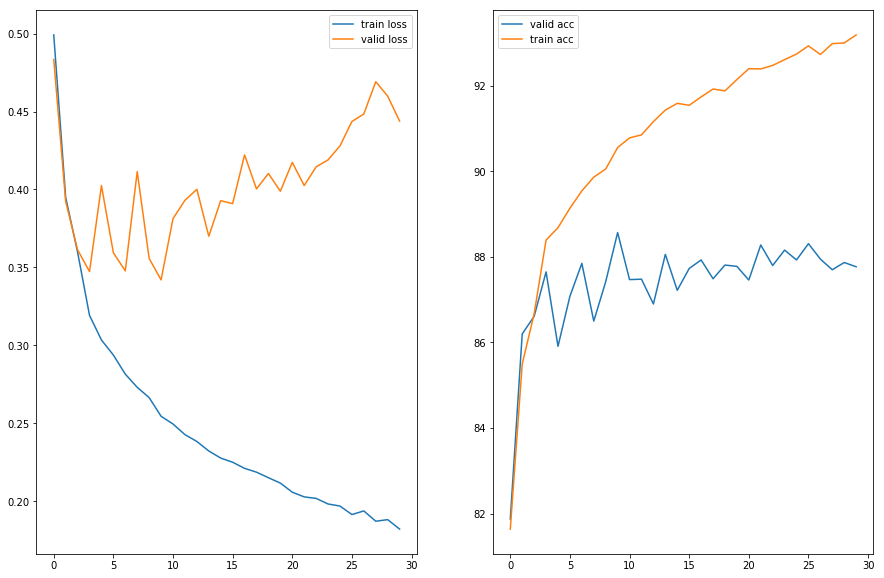

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train loss')
ax1.plot(mean_valid_losses, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.plot(train_acc_list, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')


In [0]:
test_acc_list=[]

In [50]:
for epoch in range (start_epoch):
    correct_te = 0
    total_te = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            _, predicted_te = torch.max(outputs.data, 1)
            correct_te += (predicted_te == labels).sum().item()
            total_te += labels.size(0)
    accuracy_te = 100*correct_te/total_te
    test_acc_list.append(accuracy_te)
    print('epoch: {0}, test accuracy: {1}%'.format(epoch+1,accuracy_te))
print('rata2 : {}'.format(np.mean(test_acc_list)))

epoch: 1, test accuracy: 87.14%
epoch: 2, test accuracy: 87.14%
epoch: 3, test accuracy: 87.14%
epoch: 4, test accuracy: 87.14%
epoch: 5, test accuracy: 87.14%
epoch: 6, test accuracy: 87.14%
epoch: 7, test accuracy: 87.14%
epoch: 8, test accuracy: 87.14%
epoch: 9, test accuracy: 87.14%
epoch: 10, test accuracy: 87.14%
epoch: 11, test accuracy: 87.14%
epoch: 12, test accuracy: 87.14%
epoch: 13, test accuracy: 87.14%
epoch: 14, test accuracy: 87.14%
epoch: 15, test accuracy: 87.14%
epoch: 16, test accuracy: 87.14%
epoch: 17, test accuracy: 87.14%
epoch: 18, test accuracy: 87.14%
epoch: 19, test accuracy: 87.14%
epoch: 20, test accuracy: 87.14%
rata2 : 87.14


# weight decay 0.001

In [0]:
#optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001, rho=0.9, eps=1e-06, weight_decay=0)
#loss_fn = nn.CrossEntropyLoss()
loss_fn1 = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
mean_train_losses1 = []
mean_valid_losses1 = []
valid_acc_list1 = []
train_acc_list1=[]
start_epoch1=0
e1=10

In [61]:
for epoch in range(start_epoch1,20):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer1.zero_grad()
        
        outputs = model(images)
        loss = loss_fn1(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i*1400)%(1400*1400)==0:
            print(i*10)
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn1(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses1.append(m_t_l)
    mean_valid_losses1.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list1.append(accuracy_v)
    train_acc_list1.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer1.state_dict(), 'train loss': mean_train_losses1,'train acc': train_acc_list1, 'valid loss':mean_valid_losses1, 'valid acc': valid_acc_list1}, 'mlpw0.004.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list1),np.min( mean_train_losses1)))

0
14000
28000
42000
56000
epoch : 1, train loss : 0.4120, train acc : 84.95 valid loss : 0.3901, valid acc : 85.75%
0
14000
28000
42000
56000
epoch : 2, train loss : 0.3943, train acc : 85.55 valid loss : 0.3983, valid acc : 85.31%
0
14000
28000
42000
56000
epoch : 3, train loss : 0.3861, train acc : 85.91 valid loss : 0.3843, valid acc : 86.31%
0
14000
28000
42000
56000
epoch : 4, train loss : 0.3812, train acc : 85.99 valid loss : 0.4256, valid acc : 83.87%
0
14000
28000
42000
56000
epoch : 5, train loss : 0.3768, train acc : 86.18 valid loss : 0.4064, valid acc : 85.21%
0
14000
28000
42000
56000
epoch : 6, train loss : 0.3763, train acc : 86.21 valid loss : 0.3957, valid acc : 85.45%
0
14000
28000
42000
56000
epoch : 7, train loss : 0.3747, train acc : 86.17 valid loss : 0.4314, valid acc : 84.65%
0
14000
28000
42000
56000
epoch : 8, train loss : 0.3758, train acc : 86.08 valid loss : 0.3806, valid acc : 86.04%
0
14000
28000
42000
56000
epoch : 9, train loss : 0.3703, train acc : 86

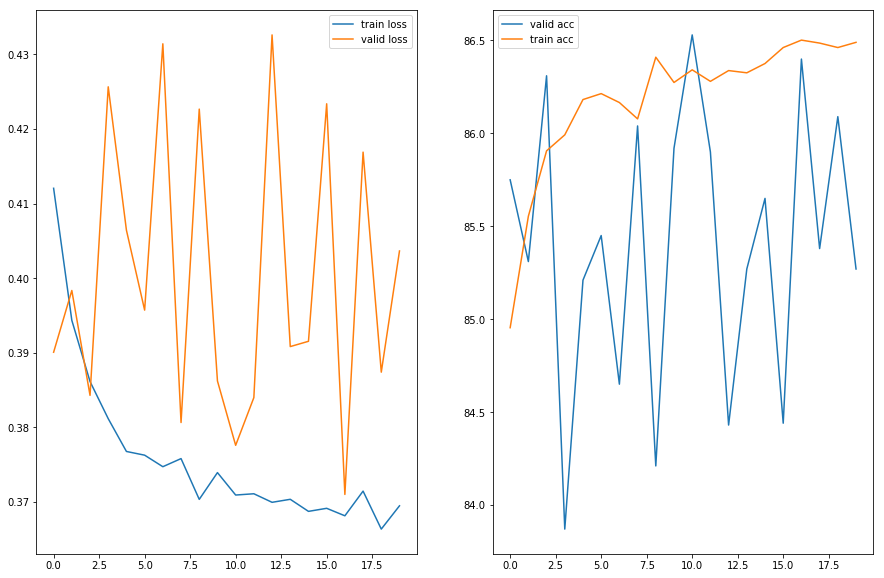

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses1, label='train loss')
ax1.plot(mean_valid_losses1, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list1, label='valid acc')
ax2.plot(train_acc_list1, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

#drop out

In [64]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10),
            nn.LogSoftmax(1)            
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x
model = MLP().to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): LogSoftmax()
  )
)


In [0]:
#optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001, rho=0.9, eps=1e-06, weight_decay=0)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [0]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
train_acc_list=[]
start_epoch=0
e=10

In [80]:
for epoch in range(start_epoch,20):
    exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i*1600)%(1600*1600)==0:
            print(i*10)
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses.append(m_t_l)
    mean_valid_losses.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list.append(accuracy_v)
    train_acc_list.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'train loss': mean_train_losses,'train acc': train_acc_list, 'valid loss':mean_valid_losses, 'valid acc': valid_acc_list}, 'mlpdo.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list),np.min( mean_train_losses)))

0
16000
32000
48000
epoch : 1, train loss : 0.3440, train acc : 87.40 valid loss : 0.3759, valid acc : 86.63%
0
16000
32000
48000
epoch : 2, train loss : 0.3311, train acc : 87.96 valid loss : 0.3541, valid acc : 87.57%
0
16000
32000
48000
epoch : 3, train loss : 0.3220, train acc : 88.13 valid loss : 0.3593, valid acc : 86.82%
0
16000
32000
48000
epoch : 4, train loss : 0.2691, train acc : 90.08 valid loss : 0.3273, valid acc : 88.17%
0
16000
32000
48000
epoch : 5, train loss : 0.2630, train acc : 90.34 valid loss : 0.3267, valid acc : 88.12%
0
16000
32000
48000
epoch : 6, train loss : 0.2603, train acc : 90.44 valid loss : 0.3264, valid acc : 88.37%
0
16000
32000
48000
epoch : 7, train loss : 0.2578, train acc : 90.56 valid loss : 0.3249, valid acc : 88.28%
0
16000
32000
48000
epoch : 8, train loss : 0.2560, train acc : 90.56 valid loss : 0.3269, valid acc : 88.12%
0
16000
32000
48000
epoch : 9, train loss : 0.2497, train acc : 90.84 valid loss : 0.3230, valid acc : 88.30%
0
16000
32

In [0]:
checkpoint = torch.load('mlpdo.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
mean_train_losses = checkpoint['train loss']
train_acc_list=checkpoint['train acc']
mean_valid_losses = checkpoint['valid loss']
valid_acc_list=checkpoint['valid acc']

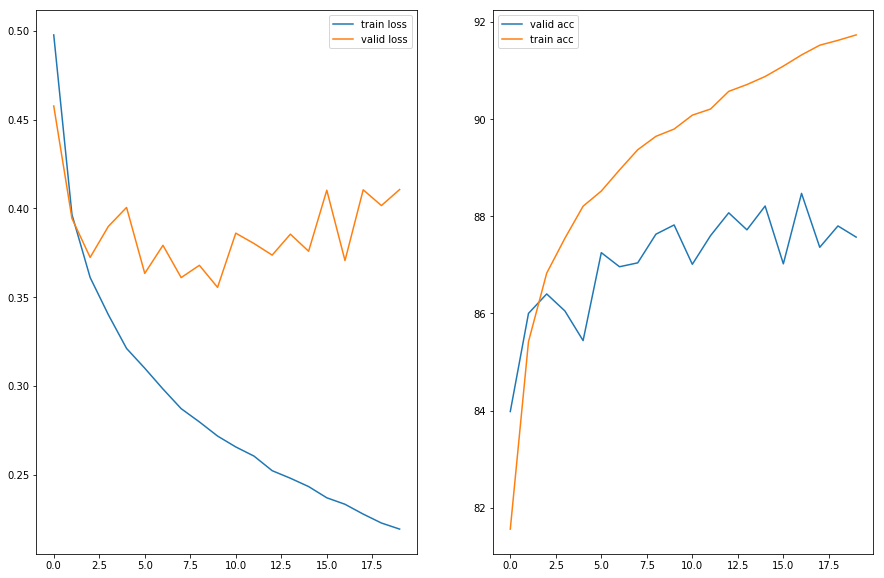

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train loss')
ax1.plot(mean_valid_losses, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.plot(train_acc_list, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
test_acc_list=[]

In [85]:
for epoch in range (start_epoch):
    correct_te = 0
    total_te = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            _, predicted_te = torch.max(outputs.data, 1)
            correct_te += (predicted_te == labels).sum().item()
            total_te += labels.size(0)
    accuracy_te = 100*correct_te/total_te
    test_acc_list.append(accuracy_te)
    print('epoch: {0}, test accuracy: {1}%'.format(epoch+1,accuracy_te))
print('rata2 : {}'.format(np.mean(test_acc_list)))

epoch: 1, test accuracy: 87.35%
epoch: 2, test accuracy: 87.35%
epoch: 3, test accuracy: 87.35%
epoch: 4, test accuracy: 87.35%
epoch: 5, test accuracy: 87.35%
epoch: 6, test accuracy: 87.35%
epoch: 7, test accuracy: 87.35%
epoch: 8, test accuracy: 87.35%
epoch: 9, test accuracy: 87.35%
epoch: 10, test accuracy: 87.35%
epoch: 11, test accuracy: 87.35%
epoch: 12, test accuracy: 87.35%
epoch: 13, test accuracy: 87.35%
epoch: 14, test accuracy: 87.35%
epoch: 15, test accuracy: 87.35%
epoch: 16, test accuracy: 87.35%
epoch: 17, test accuracy: 87.35%
epoch: 18, test accuracy: 87.35%
epoch: 19, test accuracy: 87.35%
epoch: 20, test accuracy: 87.35%
rata2 : 87.34999999999998
